# Problem 2: Regression on Weather Data


     dewptc  hum  wndspd  pressure  rain  smoke  temp
0        28   59      20      1008     0      0    20
1        48   61      10      1012     1      0    21
2        24   53       3      1001     0      0    16
3        17   54       8      1002     0      0    16
4        27   51       5      1007     0      0    14
..      ...  ...     ...       ...   ...    ...   ...
995      46   51      14       998     0      1    15
996      40   54      12      1012     0      1    16
997      27   51      13      1021     0      0    15
998      38   48      15      1006     1      1    13
999      38   96      17      1005     1      0    30

[1000 rows x 7 columns]


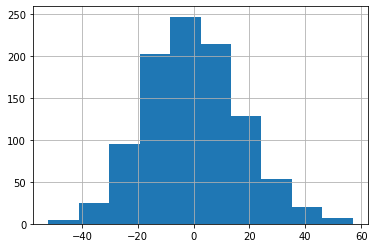

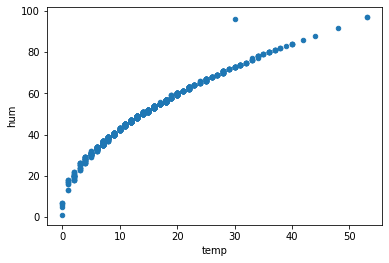

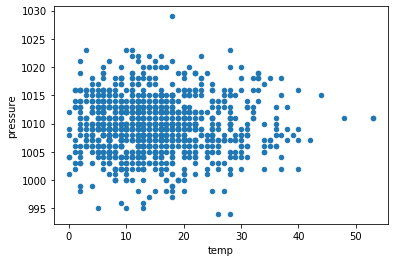

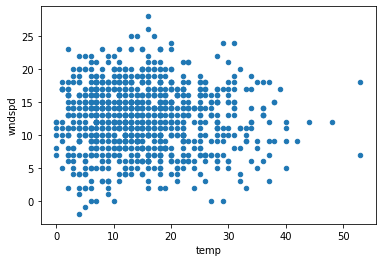

In [133]:
import pandas as pd
import numpy as np
from math import sqrt
from math import pi
from math import exp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

df = pd.read_csv('weather_data.csv')

#Rearranging columns in the input

cols = df.columns.tolist()

print(df)
df['dewptc'].diff().hist()


df.plot.scatter(x='temp',y='hum')
df.plot.scatter(x='temp',y='pressure')
df.plot.scatter(x='temp',y='wndspd')

# Data Preparation

## Splitting into Test and Train sets

In [134]:
#Linear Regression

#randomize indices, take the first 80% of the indices and last 20 percent as test
indices = np.random.permutation(df.shape[0])
train_ind, test_ind = indices[:int(0.7*df.shape[0])], indices[int(0.7*df.shape[0]):]
# print(len(train_ind), len(test_ind))

#select the data corresponding to the train and test indices and save into 2 dataframes. Reset index afterwards
train_df, test_df = df.loc[train_ind, :], df.loc[test_ind, :]
train_df, test_df = train_df.reset_index(), test_df.reset_index()

## Data Augmentation and Normalisation

A column of ones is added to represent the "feature" which allows the bias term to be processed with the other coefficients. The columns of non-binary data are normalised by subtracting their mean and dividing by the standard variation of the column. This allows for good convergence and simplifies comparision of results between different methods.

In [135]:
x_train = train_df.iloc[:,1:7]
y_train = train_df.iloc[:,7]

x_test = test_df.iloc[:,1:7]
y_test = test_df.iloc[:,7]

#augmenting data to include constant term
x_train['ones'] = 1
x_test['ones'] = 1

print(x_train.head())
print(y_train.head())

# x_train['dewptc'] = (x_train['dewptc']-x_train['dewptc'].mean())/(x_train['dewptc'].std())
# x_train['hum'] = (x_train['hum']-x_train['hum'].mean())/(x_train['hum'].std())
# x_train['wndspd'] = (x_train['wndspd']-x_train['wndspd'].mean())/(x_train['wndspd'].std())
# x_train['pressure'] = (x_train['pressure']-x_train['pressure'].mean())/(x_train['pressure'].std())
# normalizing columns
for col in ['dewptc', 'hum', 'wndspd', 'pressure']:
    x_train[col] = (x_train[col]-x_train[col].mean())/(x_train[col].std())
    x_test[col] = (x_test[col]-x_test[col].mean())/(x_test[col].std())


   dewptc  hum  wndspd  pressure  rain  smoke  ones
0      33   59      18      1011     0      0     1
1      30   55      10      1006     0      0     1
2      45   39      15      1013     0      1     1
3      37   41      12      1010     1      1     1
4      39   25      14      1014     0      0     1
0    20
1    17
2     8
3     9
4     3
Name: temp, dtype: int64


## Solving Linear Regression Using Linear Algebra (Pseudoinverse Method)

Using the normal equation to find the least squares value of W, given by ((X'X)-1)X'Y where X = feature matrix (train data) Y = output values (train data). Later it is shown that it is indeed equivalent to L2 regression with 0 constant of regularisation

In [143]:
X = x_train.to_numpy()
X_valid = X[0:X.shape[0]//5]
X_train = X[X.shape[0]//5:]
Y = y_train.to_numpy()
Y_valid = Y_train[0:X.shape[0]//5].reshape((-1, 1))
Y_train = Y[X.shape[0]//5:].reshape((-1, 1))
print(X_train.shape, X_valid.shape, Y_train.shape, Y_valid.shape)

(560, 7) (140, 7) (560, 1) (140, 1)


In [144]:
def mse_loss(Y_true,Y_pred):
    return ((Y_true-Y_pred)**2).mean()

(7, 560)
(7, 1) (560, 7) (140, 7)
(140, 1) (560, 1) (560, 1) (140, 1)
train loss 2.74391594851433
valid loss 134.21347209506192


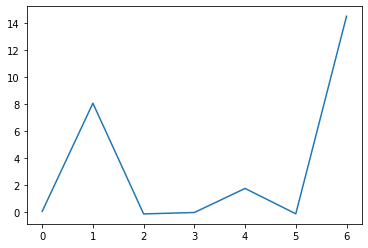

W learnt from pseudoinverse is [[ 0.05046361]
 [ 8.06377395]
 [-0.13327893]
 [-0.02878198]
 [ 1.75320847]
 [-0.12486368]
 [14.50177536]]


In [146]:
P_inv_X = np.linalg.pinv(X_train)
print(P_inv_X.shape)

W_pinv = np.matmul(P_inv_X, Y_train)
print(W_pinv.shape, X_train.shape, X_valid.shape)

y_pred_train = X_train.dot(W_pinv)
y_pred_valid = X_valid.dot(W_pinv)

print(Y_valid.shape, Y_train.shape, y_pred_train.shape, y_pred_valid.shape)
print("train loss", mse_loss(Y_train,y_pred_train))
print("valid loss", mse_loss(Y_valid,y_pred_valid))

plt.plot(W_pinv)
plt.show()
print('W learnt from pseudoinverse is', W_pinv)

#predict


In [126]:
def Get_W_NoReg(X,y):
    # can use pseudo inverse - it is more powerful in terms of its properties (mathematics)
    return (np.linalg.inv(X.T.dot(X))).dot(X.T).dot(y)

W = Get_W_NoReg(X_train,Y_train)

y_pred_train = X_train.dot(W)
y_pred_valid = X_valid.dot(W)

print("train loss", mse_loss(Y_train,y_pred_train))
print("test loss", mse_loss(Y_valid,y_pred_valid))

train loss 2.684544010410155
test loss 151.0299770250568


# Gradient Descent Methods

In [81]:
X_test = x_test.to_numpy()
X_train = x_train.to_numpy()
Y_test = y_test.to_numpy()
Y_test = Y_test.reshape((Y_test.shape[0],1))
Y_train = y_train.to_numpy()
Y_train = Y_train.reshape((Y_train.shape[0],1))

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(700, 7)
(300, 7)
(700, 1)
(300, 1)


In [87]:
num_iter = 200
rate = 0.1
W = np.random.rand(X_train.shape[1],1)

### MSE Loss without Regularisation

[[ 0.04845911]
 [ 7.93513751]
 [-0.07900972]
 [-0.02195567]
 [ 2.01880982]
 [-0.03253036]
 [14.40249002]]
2.684953368865976
4.283715153245196


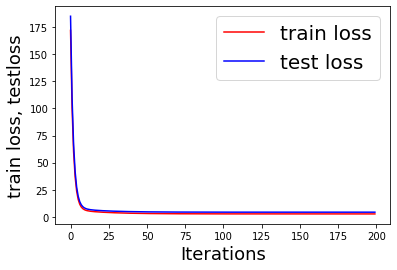

In [105]:
def loss(W,X,Y):
    # W = np.random.rand(7,1)
    square_loss = np.mean((np.matmul(X,W) - Y)**2)
    return square_loss

def gradient(W,X,Y):
    grad = -2*np.matmul(X.T,(np.matmul(X,W) - Y))/X.shape[0]
    return grad

def sgd(W,X,Y,X_test,Y_test,rate,num_iter):
    train_loss, test_loss = [], []
    for _ in range(0, num_iter):
        grad = gradient(W,X,Y)
        W = W + rate*grad
        train_loss.append(loss(W,X,Y))
        test_loss.append(loss(W,X_test,Y_test))
    return W, train_loss, test_loss

W0 = np.random.rand(X_train.shape[1],1)*0.01

W0, train_loss, test_loss = sgd(W0,X_train,Y_train,X_valid,Y_valid,rate,num_iter)
W_mse = W0
print(W0)
print(train_loss[-1])
print(test_loss[-1])

plt.plot(train_loss, 'r', label = 'train loss')
plt.plot(test_loss, 'b', label = 'test loss')
plt.xlabel('Iterations', fontsize=18)
plt.ylabel('train loss, testloss', fontsize=18)
plt.legend(prop={'size': 20})
plt.show()

### MSE Loss with L1 Regularisation

[[-0.47533221]
 [ 7.7452274 ]
 [-0.70113332]
 [-0.46104784]
 [ 0.7084144 ]
 [-2.15606612]
 [14.80945448]]
32.116900149263266
31.841262861223335


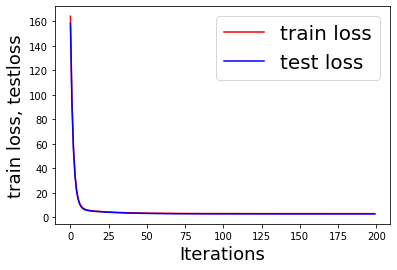

In [104]:
def lossL1(W,X,Y,lam):
    square_loss = np.mean((np.matmul(X,W) - Y)**2) + lam*np.sum(np.abs(W))
    return square_loss

def gradientL1(W,X,Y,lam):
    W_grad = np.zeros(W.shape)
    for i in range(W_grad.shape[0]):
        if(W[i] > 0):
            W_grad = 1
        else:
            W_grad = -1
    grad = -2*np.matmul(X.T,(np.matmul(X,W)-Y))/X.shape[0] - lam*W_grad
    #print(grad)
    return grad

def sgdL1(W,X,Y,X_test,Y_test,rate,num_iter,lam):
    train_loss, test_loss = [], []
    for _ in range(0, num_iter):
        grad = gradientL1(W,X,Y,lam)
 
        W = W + rate*grad
        train_loss.append(lossL1(W,X,Y,lam))
        test_loss.append(lossL1(W,X_test,Y_test,lam))
    return W, train_loss, test_loss

lam1 = 1

W1 = np.random.rand(X_train.shape[1],1)

W1, train_lossL1, test_lossL1 = sgdL1(W1,X_train,Y_train,X_test,Y_test,rate,num_iter,lam1)
W_mse_l1 = W1
print(W1)
print(train_lossL1[-1])
print(test_lossL1[-1])

plt.plot(train_loss, 'r', label = 'train loss')
plt.plot(test_loss, 'b', label = 'test loss')
plt.xlabel('Iterations', fontsize=18)
plt.ylabel('train loss, testloss', fontsize=18)
plt.legend(prop={'size': 20})
plt.show()

### MSE Loss with L2 Regularisation

[[-5.01125520e-02]
 [ 6.79641338e+00]
 [-8.50832755e-03]
 [-5.35822161e-02]
 [ 3.81908140e+00]
 [ 1.25172979e+00]
 [ 1.22541229e+01]]
27.038595773474597
26.364305961549675


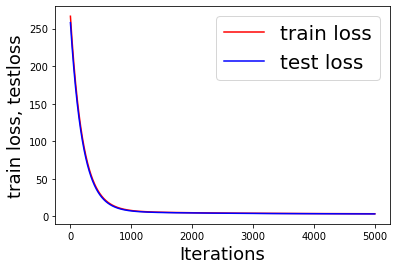

In [44]:
def lossL2(W,X,Y,lam):
    square_loss = np.mean((np.matmul(X,W) - Y)**2) + lam*np.sum(np.multiply(W,W))
    return square_loss

def gradientL2(W,X,Y,lam):
    grad = -2*np.matmul(X.T,(np.matmul(X,W) - Y))/X.shape[0] - 2*lam*W
    return grad

def sgdL2(W,X,Y,X_test,Y_test,rate,num_iter,lam):
    train_loss, test_loss = [], []
    for _ in range(0, num_iter):
        grad = gradientL2(W,X,Y,lam)
    
        W = W + rate*grad
        train_loss.append(lossL2(W,X,Y,lam))
        test_loss.append(lossL2(W,X_test,Y_test,lam))
    return W, train_loss, test_loss

lam2 = 0.1

W2 = np.random.rand(X_train.shape[1],1)

W2, train_lossL2, test_lossL2 = sgdL2(W2,X_train,Y_train,X_test,Y_test,rate,num_iter,lam2)

print(W2)
print(train_lossL2[-1])
print(test_lossL2[-1])

plt.plot(train_loss, 'r', label = 'train loss')
plt.plot(test_loss, 'b', label = 'test loss')
plt.xlabel('Iterations', fontsize=18)
plt.ylabel('train loss, testloss', fontsize=18)
plt.legend(prop={'size': 20})
plt.show()

### MSE Loss with Elastic Net Regulariser

Using 5 times the number of iterations

[[2.69742089e-02]
 [6.41854718e+00]
 [5.36203653e-03]
 [3.12958018e-02]
 [5.00968247e+00]
 [1.99143912e+00]
 [1.11609831e+01]]
28.13307964246717
28.77932144035984


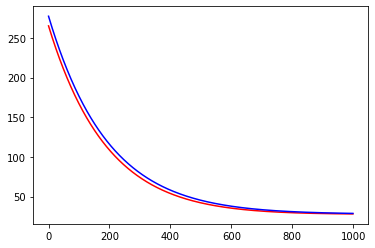

In [328]:
def lossE(W,X,Y,lam1, lam2):
    square_loss = np.mean((np.matmul(X,W) - Y)**2) + lam1*np.sum(np.multiply(W,W)) + lam2*np.sum(np.abs(W))
    return square_loss

def gradientE(W,X,Y,lam1, lam2):
    W_grad = np.zeros(W.shape)
    for i in range(W_grad.shape[0]):
        if(W[i] > 0):
            W_grad = 1
        else:
            W_grad = -1
    grad = -2*np.matmul(X.T,(np.matmul(X,W) - Y))/X.shape[0] - 2*lam2*W - lam1*W_grad
    return grad

def sgdE(W,X,Y,X_test,Y_test,rate,num_iter,lam1,lam2):
    train_loss, test_loss = [], []
    for _ in range(0, num_iter):
        grad = gradientE(W,X,Y,lam1,lam2)
    
        W = W + rate*grad
        train_loss.append(lossE(W,X,Y,lam1,lam2))
        test_loss.append(lossE(W,X_test,Y_test,lam1,lam2))
    return W, train_loss, test_loss

WE = np.random.rand(X_train.shape[1],1)

lam3 = 0.1
lam4 = 0.01

WE, train_loss_E, test_loss_E = sgdE(WE,X_train,Y_train,X_test,Y_test,rate,num_iter*5,lam3,lam4)

print(WE)
print(train_loss_E[-1])
print(test_loss_E[-1])

plt.plot(train_loss_E, 'r')
plt.plot(test_loss_E, 'b')
plt.show()

## Mean Absolute Error Loss

Using a 100 times lower learning rate for convergence

In [312]:
rate = rate/100

## MAE Loss without regularisation

In [313]:
def loss_mae(W,X,Y):
    mae_loss = np.mean(np.abs(np.matmul(X,W) - Y))
    return mae_loss

def grad_mae(W,X,Y):
    Y_pred = np.matmul(X,W)
    Y_grad = np.copy(Y_pred)
    for i in range(Y_grad.shape[0]):
        if(Y_pred[i,0] > Y[i,0]):
            Y_grad[i,0] = 1
        else:
            Y_grad[i,0] = -1
        
    return np.matmul(X.T,Y_grad)

def sgd_mae(W,X,Y,X_test,Y_test,rate,num_iter):
    train_loss, test_loss = [], []
    for _ in range(num_iter):
        grad = grad_mae(W,X,Y)
        W = W-rate*grad
        train_loss.append(loss_mae(W,X,Y))
        test_loss.append(loss_mae(W,X_test,Y_test))
    
    return W, train_loss, test_loss

[[ 4.60243487e-02]
 [ 8.14632011e+00]
 [-1.20884671e-02]
 [-5.03104258e-02]
 [ 1.50909209e+00]
 [ 7.45930525e-02]
 [ 1.38864829e+01]]


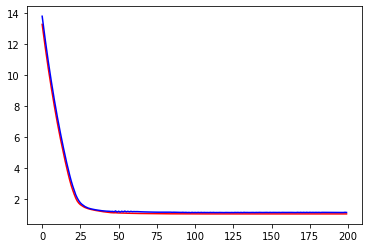

In [314]:
W_mae = np.random.rand(X_train.shape[1],1)

W_mae, train_loss_mae, test_loss_mae = sgd_mae(W_mae,X_train,Y_train,X_test,Y_test,rate,num_iter)

print(W_mae)

plt.plot(train_loss_mae,'r')
plt.plot(test_loss_mae,'b')
plt.show()

## Mean Absolute Error with L1 Regularisation

In [315]:
def loss_mae_L1(W,X,Y,lam):
    mae_loss = np.mean(np.abs(np.matmul(X,W) - Y)) + lam*np.sum(np.abs(W))
    return mae_loss

def grad_mae_L1(W,X,Y,lam):
    Y_pred = np.matmul(X,W)
    Y_grad = np.copy(Y_pred)
    for i in range(Y_grad.shape[0]):
        if(Y_pred[i,0] > Y[i,0]):
            Y_grad[i,0] = 1
        else:
            Y_grad[i,0] = -1
            
    W_grad = np.zeros(W.shape)
    for i in range(W_grad.shape[0]):
        if(W[i] > 0):
            W_grad = 1
        else:
            W_grad = -1
            
    return np.matmul(X.T,Y_grad) + lam*W_grad

def sgd_mae_L1(W,X,Y,X_test,Y_test,rate,num_iter,lam):
    train_loss, test_loss = [], []
    for _ in range(num_iter):
        grad = grad_mae_L1(W,X,Y,lam)
        W = W-rate*grad
        train_loss.append(loss_mae_L1(W,X,Y,lam))
        test_loss.append(loss_mae_L1(W,X_test,Y_test,lam))
    
    return W, train_loss, test_loss

[[ 4.46244823e-02]
 [ 8.14449265e+00]
 [-1.10556003e-02]
 [-5.07507964e-02]
 [ 1.51151870e+00]
 [ 7.19998742e-02]
 [ 1.38860927e+01]]


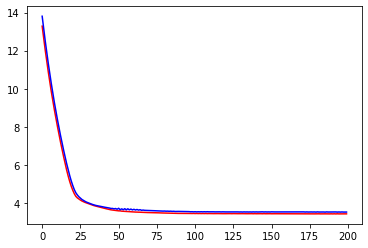

In [316]:
W_mae_L1 = np.random.rand(X_train.shape[1],1)

lam5 = 0.1

W_mae_L1, train_loss_mae_L1, test_loss_mae_L1 = sgd_mae_L1(W_mae_L1,X_train,Y_train,X_test,Y_test,rate,num_iter,lam5)

print(W_mae_L1)

plt.plot(train_loss_mae_L1,'r')
plt.plot(test_loss_mae_L1,'b')
plt.show()

## Mean Absolute Error with L2 Regularisation

In [317]:
def loss_mae_L2(W,X,Y,lam):
    mae_loss = np.mean(np.abs(np.matmul(X,W) - Y)) + lam*np.sum(np.multiply(W,W))
    return mae_loss

def grad_mae_L2(W,X,Y,lam):
    Y_pred = np.matmul(X,W)
    Y_grad = np.copy(Y_pred)
    for i in range(Y_grad.shape[0]):
        if(Y_pred[i,0] > Y[i,0]):
            Y_grad[i,0] = 1
        else:
            Y_grad[i,0] = -1
            
    return np.matmul(X.T,Y_grad) + 2*lam*W

def sgd_mae_L2(W,X,Y,X_test,Y_test,rate,num_iter,lam):
    train_loss, test_loss = [], []
    for _ in range(num_iter):
        grad = grad_mae_L2(W,X,Y,lam)
        W = W-rate*grad
        train_loss.append(loss_mae_L2(W,X,Y,lam))
        test_loss.append(loss_mae_L2(W,X_test,Y_test,lam))
    
    return W, train_loss, test_loss

[[ 3.55199937e-02]
 [ 8.14374363e+00]
 [-5.66561379e-03]
 [-5.19797548e-02]
 [ 1.50993985e+00]
 [ 7.83063152e-02]
 [ 1.38872258e+01]]


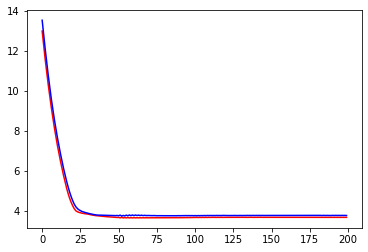

In [318]:
W_mae_L2 = np.random.rand(X_train.shape[1],1)

lam6 = 0.01

W_mae_L2, train_loss_mae_L2, test_loss_mae_L2 = sgd_mae_L2(W_mae_L2,X_train,Y_train,X_test,Y_test,0.001,num_iter,lam6)

print(W_mae_L2)

plt.plot(train_loss_mae_L2,'r')
plt.plot(test_loss_mae_L2,'b')
plt.show()

## Mean Absolute Error with Elastic Net Regularisation

In [319]:
def loss_mae_E(W,X,Y,lam1,lam2):
    mae_loss = np.mean(np.abs(np.matmul(X,W) - Y)) + lam1*np.sum(np.abs(W)) + lam2*np.sum(np.multiply(W,W))
    return mae_loss

def grad_mae_E(W,X,Y,lam1,lam2):
    Y_pred = np.matmul(X,W)
    Y_grad = np.copy(Y_pred)
    for i in range(Y_grad.shape[0]):
        if(Y_pred[i,0] > Y[i,0]):
            Y_grad[i,0] = 1
        else:
            Y_grad[i,0] = -1
            
    W_grad = np.zeros(W.shape)
    for i in range(W_grad.shape[0]):
        if(W[i] > 0):
            W_grad = 1
        else:
            W_grad = -1
            
    return np.matmul(X.T,Y_grad) + lam1*W_grad + 2*lam2*W

def sgd_mae_E(W,X,Y,X_test,Y_test,rate,num_iter,lam1,lam2):
    train_loss, test_loss = [], []
    for _ in range(num_iter):
        grad = grad_mae_E(W,X,Y,lam1,lam2)
        W = W-rate*grad
        train_loss.append(loss_mae_E(W,X,Y,lam1,lam2))
        test_loss.append(loss_mae_E(W,X_test,Y_test,lam1,lam2))
    
    return W, train_loss, test_loss

[[ 3.83610625e-02]
 [ 8.15029003e+00]
 [-7.11793647e-03]
 [-5.46631958e-02]
 [ 1.50664417e+00]
 [ 7.24352158e-02]
 [ 1.38766365e+01]]


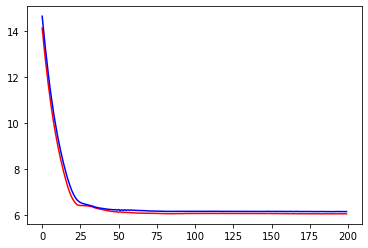

In [320]:
W_mae_E = np.random.rand(X_train.shape[1],1)

lam7 = 0.1
lam8 = 0.01

W_mae_E, train_loss_mae_E, test_loss_mae_E = sgd_mae_E(W_mae_E,X_train,Y_train,X_test,Y_test,0.001,num_iter,lam7,lam8)

print(W_mae_E)

plt.plot(train_loss_mae_E,'r')
plt.plot(test_loss_mae_E,'b')
plt.show()

## Log-cosh Loss

A loss function with several desirable properties. log(cosh(x)) is approximately x^2/2 close to the origin and mod(x) - log(2) away from the origin. Hence it works like MSE, however it is not as sensitive to outliers. It is also twice differentiable everywhere, allowing algorithms to use Newton's method (a second order method) to learn instead of gradient descent techniques. Here the gradient descent implementation is provided.

In [321]:
def loss_logcosh(W,X,Y):
    loss = np.log(np.cosh(np.matmul(X,W) - Y))
    return np.mean(loss)

def grad_logcosh(W,X,Y):
    diff = np.matmul(X,W) - Y
    return np.matmul(X.T,np.tanh(diff))/X.shape[0]

def sgd_logcosh(W,X,Y,X_test,Y_test,rate,num_iter):
    train_loss, test_loss = [], []
    for _ in range(num_iter):
        grad = grad_logcosh(W,X,Y)
        W = W - rate*grad
        train_loss.append(loss_logcosh(W,X,Y))
        test_loss.append(loss_logcosh(W,X_test,Y_test))
    return W, train_loss, test_loss

[[ 0.03339902]
 [ 8.13565296]
 [-0.02696284]
 [-0.04942409]
 [ 1.56266666]
 [ 0.06863812]
 [13.97990208]]


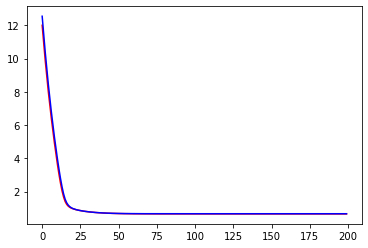

In [322]:
W_logcosh = np.random.rand(X_train.shape[1],1)

W_logcosh, train_loss_lc, test_loss_lc = sgd_logcosh(W_logcosh,X_train,Y_train,X_test,Y_test,1,num_iter)

print(W_logcosh)

plt.plot(train_loss_lc,'r')
plt.plot(test_loss_lc,'b')
plt.show()

## Comparision of the Parameters learnt by each method

## MSE Loss Methods

### Observations:

Push towards sparsity of L1 regularisation can be observed. It also strongly pushes to 0 the parameters which were already close to 0 hence eliminating some features. 

L2 regularisation changes the impacts of each feature trying to improve the quality of each feature. 

These aspects are also seen in Elastic Net Regularisation as it combines both L1 and L2 regularisers. 

The points learnt using the pseudoinverse method overlap with the points learnt without a regulariser hence showing numerically that the normal equation method is identical to no regularisation with square loss.

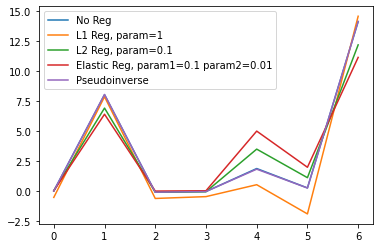

In [329]:
plt.plot(W0, label='No Reg')
plt.plot(W1, label='L1 Reg, param=' + str(lam1))
plt.plot(W2, label='L2 Reg, param=' + str(lam2))
plt.plot(WE, label='Elastic Reg, ' + 'param1=' + str(lam3) + ' param2=' + str(lam4))
plt.plot(W_pinv, label='Pseudoinverse')
plt.legend()
plt.show()


## MAE Loss Methods

### Observations


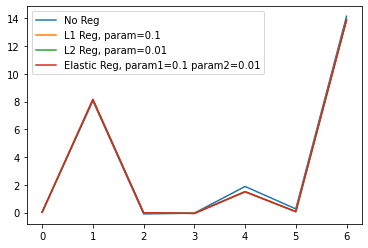

In [324]:
plt.plot(W0, label='No Reg') 
plt.plot(W_mae_L1, label='L1 Reg, param='+ str(lam5))
plt.plot(W_mae_L2,label='L2 Reg, param=' + str(lam6))
plt.plot(W_mae_E, label='Elastic Reg, param1=' + str(lam7) + ' param2=' + str(lam8))
plt.legend()
plt.show()

In [325]:
def cross_validate(data,k,rate,num_iter,lam1,lam2): 
    #shuffle the data (actual order is also changed)
    
    np.random.shuffle(data)
    
    #normalise
    
    for i in range(4):
        data_col = data[:,i]
        data_mean = data_col.mean()
        data_std = data_col.std()
        data[:,i] = (data[:,i] - data_mean)/data_std
        
    #Kfoldsplit is a list of k (almost) equal sized parts of the np array
    
    Kfoldsplit = np.array_split(data,k)
    
    #Use test_score and train_score to store the metric you want to analyse i.e. accuracy, precision, 
    
    test_score = []
    train_score = []
    
    RMSE = []
    RVAL = []
    RTRA = []
    MAE = []
    MSE = []
    
    for i in range(k):
        validation = Kfoldsplit[i]
        train = []
        
        for j in range(k):
            if(j != i):
                train.append(Kfoldsplit[j])
        
        # Start of preparing test and train numpy arrays
        # Assert: The last column is the column of predictions
        # Assert: Data is not augmented
        
        Train = np.concatenate(train,axis=0)
        X_train = Train[:,0:-1]
        train_ones = np.ones((X_train.shape[0],1))
        X_train = np.append(X_train,train_ones,axis=1)
        
        Y_train = Train[:,-1]
        Y_train = Y_train.reshape((Y_train.shape[0],1))
        
        X_validation = validation[:,0:-1]
        validation_ones = np.ones((X_validation.shape[0],1))
        X_validation = np.append(X_validation,validation_ones,axis=1)
        Y_validation = validation[:,-1]
        Y_validation = Y_validation.reshape((Y_validation.shape[0],1))
        
        # End of preparing dataset
        
        # Replace the following with appropriate algorithm
        
        W = np.random.rand(X_train.shape[1],1)

        W, train_loss, validation_loss = sgdE(W,X_train,Y_train,X_validation,Y_validation,rate,num_iter,lam1,lam2)
        
       # rmse = sqrt(np.mean((np.matmul(X_test,W) - Y_test)**2))
        rval = sqrt(np.mean((np.matmul(X_validation,W) - Y_validation)**2))
       
        rtra = sqrt(np.mean((np.matmul(X_train     ,W) - Y_train     )**2))
       # mae = np.mean(np.abs(np.matmul(X_test,W) - Y_test))
        
        
      #  RMSE.append(rmse)
        RVAL.append(rval)
        RTRA.append(rtra)
       # MAE.append(mae)
        
    return RTRA, RVAL

In [326]:

intervals = 21
lam1_set = np.linspace(0,1,intervals)
lam2_set = np.linspace(0,0.1,intervals)

RVAL = np.zeros((21,21))
RTRA = np.zeros((21,21))

for i in range(lam1_set.shape[0]):
    for j in range(lam2_set.shape[0]):
        rval, rtra = cross_validate(numpy_df,5,rate,num_iter,lam1_set[i],lam2_set[j])
        RVAL[i,j] = (np.mean(rval))
        RTRA[i,j] = (np.mean(rtra))
            


ValueError: input operand has more dimensions than allowed by the axis remapping

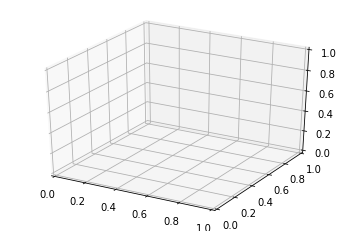

In [327]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X_axis, Y_axis = np.meshgrid(100, 100)
ax.plot(lam1_set,lam2_set,RVAL)
print(RVAL)